In [ ]:
import pandas as pd
import nltk
import string
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')

queries = pd.read_csv('data/train_queries.csv', delimiter='\t')
#queries['text'] = queries['text'].str.replace(rf"[{re.escape(string.punctuation)}]", " ", regex=True)
docs = pd.read_json('data/docs.jsonl', lines=True)
qrels = pd.read_csv('data/train_qrels.csv', sep='\t')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christianjensen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
counts = qrels.groupby('qid').size().reset_index(name='n_relevant_docs')

# Compute statistics
avg_relevant = counts['n_relevant_docs'].mean()
max_relevant = counts['n_relevant_docs'].max()
min_relevant = counts['n_relevant_docs'].min()

print(f"Average relevant docs per query: {avg_relevant}")
print(f"Maximum relevant docs for any query: {max_relevant}")
print(f"Minimum relevant docs for any query: {min_relevant}")

Average relevant docs per query: 1.0
Maximum relevant docs for any query: 1
Minimum relevant docs for any query: 1


In [ ]:
from pandarallel import pandarallel
import re
from bs4 import BeautifulSoup
import nltk

# pre–compile your URL regex once
url_pattern = re.compile(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+')

def clean_and_count(text):
    # strip HTML (use the faster lxml parser if you have it installed)
    text_no_html = BeautifulSoup(text, 'lxml').get_text()
    # remove URLs
    text_no_urls = url_pattern.sub('', text_no_html)
    # tokenize
    return len(nltk.word_tokenize(text_no_urls))

pandarallel.initialize(progress_bar=True)

docs['cleaned_body_word_count'] = docs['body'].parallel_apply(clean_and_count)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
print("Cleaned document length statistics:")
print(docs['cleaned_body_word_count'].describe())

Cleaned document length statistics:
count    200000.000000
mean       2130.232055
std        4037.443885
min           0.000000
25%         550.000000
50%        1035.000000
75%        2280.000000
max      413643.000000
Name: cleaned_body_word_count, dtype: float64


In [19]:
def english_tokenize_fast(text, max_term_length=20):
    """
    One-pass, linear-time tokenizer that only builds each alphanumeric token once
    and discards it immediately if it:
      • exceeds max_term_length,
      • accumulates more than 4 digits,
      • has any character repeated ≥ 4 times in a row.

    Splitting is done implicitly: we treat any non-alphanumeric char as a “token boundary.”
    """
    tokens = []
    # state for the current token under construction
    curr = []               # list of characters
    length = 0              # current token length
    digit_count = 0         # how many digits so far
    repeat_char = None      # previous character in the token
    repeat_run = 1          # how many times in a row 'repeat_char' has appeared
    is_valid = True         # assume valid until proven otherwise

    def finish_token():
        nonlocal curr, length, digit_count, repeat_char, repeat_run, is_valid
        if curr and is_valid:
            tokens.append(''.join(curr))
        # reset all state
        curr = []
        length = 0
        digit_count = 0
        repeat_char = None
        repeat_run = 1
        is_valid = True

    for c in text:
        if c.isalnum():
            # we’re inside an alphanumeric run
            if is_valid:
                length += 1
                if length > max_term_length:
                    is_valid = False
                else:
                    if c.isdigit():
                        digit_count += 1
                        if digit_count > 4:
                            is_valid = False
                    # check for ≥4 repeats in a row
                    if repeat_char is None or c != repeat_char:
                        repeat_char = c
                        repeat_run = 1
                    else:
                        repeat_run += 1
                        if repeat_run >= 4:
                            is_valid = False
            curr.append(c)
        else:
            # boundary: non‐alphanumeric
            finish_token()

    # catch the last token if text ended on alnum
    finish_token()
    return tokens

In [20]:
queries['query_word_count'] = queries['text'].apply(lambda x: len(english_tokenize_fast(x)))

print("Query length statistics:")
print(queries['query_word_count'].describe())

Query length statistics:
count    4434.000000
mean        5.763419
std         2.392127
min         2.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        22.000000
Name: query_word_count, dtype: float64


In [21]:
docs['body_word_count'] = docs['body'].apply(lambda x: len(english_tokenize_fast(x)))

print("Document length statistics:")
print(docs['body_word_count'].describe())

Document length statistics:
count    200000.000000
mean       1871.179565
std        3498.256455
min           0.000000
25%         489.000000
50%         919.000000
75%        2017.000000
max      309137.000000
Name: body_word_count, dtype: float64


In [24]:
# Mark relevant docs
relevant_ids = qrels.loc[qrels['relevance'] > 0, 'docno']
docs = docs.copy()
docs['label'] = docs['docno'].isin(relevant_ids).astype(int)

# Pre-compute totals
total_docs     = len(docs)
total_relevant = docs['label'].sum()

# Compute quartile thresholds
q1  = docs['body_word_count'].quantile(0.01)
q99 = docs['body_word_count'].quantile(0.99)

def report(mask, description):
    subset          = docs[mask]
    count           = len(subset)
    pct_of_all      = count / total_docs * 100
    relevant_count  = subset['label'].sum()
    pct_of_relevant = relevant_count / total_relevant * 100

    print(f"{count} docs {description} "
          f"({pct_of_all:.2f}% of all docs)")
    print(f"{relevant_count} relevant docs {description} "
          f"({pct_of_relevant:.2f}% of relevant docs)\n")

# Below first quartile
report(
    docs['body_word_count'] < q1,
    f"with fewer than {q1:.0f} words"
)

# Above 99th percentile
report(
    docs['body_word_count'] > q99,
    f"with more than {q99:.0f} words"
)

1956 docs with fewer than 42 words (0.98% of all docs)
11 relevant docs with fewer than 42 words (0.25% of relevant docs)

2000 docs with more than 14208 words (1.00% of all docs)
31 relevant docs with more than 14208 words (0.70% of relevant docs)



In [27]:
docs[(docs['body_word_count'] > q1) &(docs['body_word_count'] < q99)]['body_word_count'].describe()

count    195985.000000
mean       1659.705120
std        2007.935315
min          43.000000
25%         497.000000
50%         920.000000
75%        1985.000000
max       14208.000000
Name: body_word_count, dtype: float64

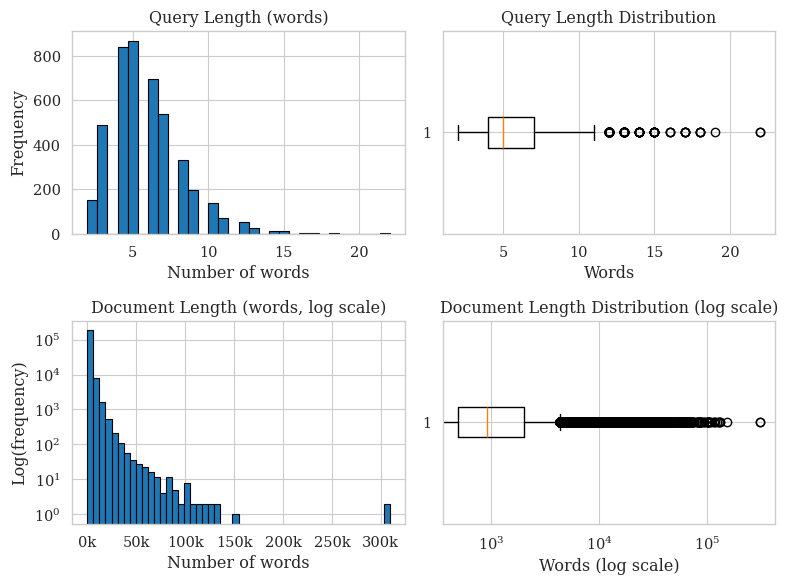

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Set a clean, serif style and larger fonts:
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)
plt.rc('font', family='serif')

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Query length histogram (words)
axes[0,0].hist(queries['query_word_count'], bins=30, edgecolor='black')
axes[0,0].set_title('Query Length (words)')
axes[0,0].set_xlabel('Number of words')
axes[0,0].set_ylabel('Frequency')

# Query boxplot
axes[0,1].boxplot(queries['query_word_count'], vert=False)
axes[0,1].set_title('Query Length Distribution')
axes[0,1].set_xlabel('Words')

# Document length histogram (log-y)
axes[1,0].hist(docs['body_word_count'], bins=50, edgecolor='black')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Document Length (words, log scale)')
axes[1,0].set_xlabel('Number of words')
axes[1,0].set_ylabel('Log(frequency)')
axes[1,0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

# Document boxplot
axes[1,1].boxplot(docs['body_word_count'], vert=False)
axes[1,1].set_title('Document Length Distribution (log scale)')
axes[1,1].set_xlabel('Words (log scale)')
axes[1,1].set_xscale('log')

plt.tight_layout()
plt.show()

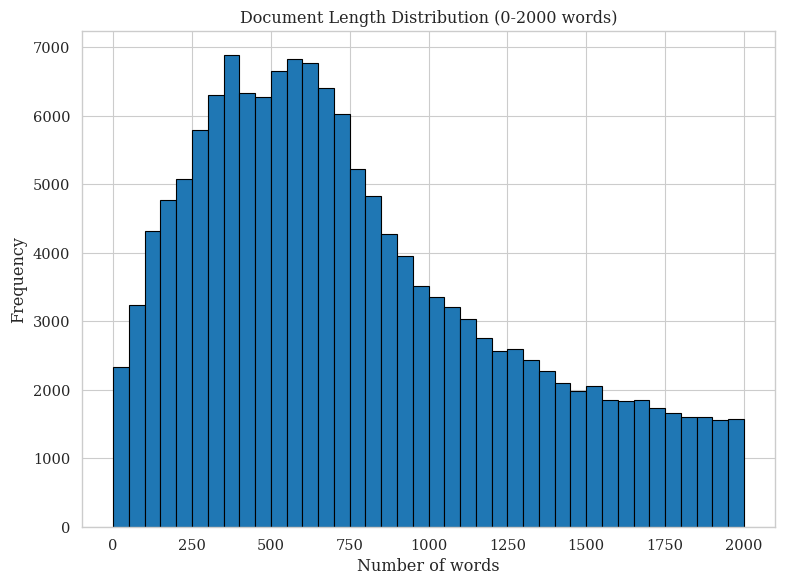

In [26]:
import matplotlib.pyplot as plt

# Plot histogram of docs up to 2 000 words
plt.figure(figsize=(8, 6))
plt.hist(
    docs['body_word_count'],
    bins=40,                # you can adjust bin count
    range=(0, 2000),        # limits x‐axis to 0–2000
    edgecolor='black'
)
plt.title('Document Length Distribution (0-2000 words)')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()